In [1]:
#3D Harmonic Coordinates

#Imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import trimesh

import numpy as np
import matplotlib.widgets as widgets
import matplotlib.tri as mtri
import ipywidgets as widgets

import scipy.sparse



Creating the Mesh and Cage - Clara Zard

In [2]:
def create_spherical_disc(center, radius, normal, disc_radius, resolution=100):
   
    theta = np.linspace(0, 2*np.pi, resolution)
    phi = np.linspace(0, np.pi/2, resolution)  # Half pi to create a flat disc
    phi, theta = np.meshgrid(phi, theta)
    
    # Spherical coordinates
    x = center[0] + radius * np.sin(phi) * np.cos(theta)
    y = center[1] + radius * np.sin(phi) * np.sin(theta)
    z = center[2] + radius * np.cos(phi)
    
    # Flatten and create vertices array
    vertices = np.stack([x.ravel(), y.ravel(), z.ravel()], axis=-1)
    
    # Triangulate the points
    faces = []
    for i in range(phi.shape[0] - 1):
        for j in range(phi.shape[1] - 1):
            idx1 = i * phi.shape[1] + j
            idx2 = idx1 + 1
            idx3 = (i + 1) * phi.shape[1] + j
            idx4 = idx3 + 1
            
            faces.append([idx1, idx2, idx3])
            faces.append([idx2, idx4, idx3])

    return trimesh.Trimesh(vertices=vertices, faces=faces)




In [3]:
#using trimesh to make the eyeball
# Create a sphere mesh
sphere_radius = 10  # Radius of the sphere
sphere_mesh = trimesh.creation.icosphere(subdivisions=3, radius=sphere_radius)
look_direction = np.array([0, 0, 0.05])  # Looking along the z-axis
look_direction2 = np.array([0, 0, 0.7])  # Looking along the z-axis


# Calculate the new center position for the iris and pupil on the sphere surface
iris_center = sphere_radius * look_direction
pupil_center = sphere_radius * look_direction2   # Assuming pupil is at the same position


# Position the iris and pupil on the sphere
iris_radius = 1
iris_mesh = create_spherical_disc(center=iris_center, radius=sphere_radius, normal=[0,0,1], disc_radius=iris_radius)


pupil_radius = 0.5
pupil_mesh = create_spherical_disc(center=pupil_center, radius=sphere_radius * 0.5 , normal=[0,0,1], disc_radius=pupil_radius)

white_color = [255, 255, 255, 255]  # RGBA colors, Alpha for index 4(255 is fully opaque)
blue_color = [0, 0, 255, 255]
black_color = [0, 0, 0, 255]

# Apply colors to each mesh
sphere_mesh.visual.vertex_colors = white_color
iris_mesh.visual.vertex_colors = blue_color
pupil_mesh.visual.vertex_colors = black_color

# Combine meshes into a single scene for visualization + for mesh deformation for later
combined_mesh = trimesh.util.concatenate([iris_mesh, pupil_mesh])

scene = trimesh.Scene([sphere_mesh,combined_mesh])

# Show the scene with a specific background color
scene.show(background=[0.5, 0.5, 0.5, 1.0])  # Grey background

In [4]:
#cage definition
cage_radius_x = sphere_radius * 1
cage_radius_y = sphere_radius * 1
cage_radius_z = sphere_radius * 1.1  

# Define cage vertices
# 6 vertices for the main directions
cage_vertices_main = [
    [cage_radius_x, 0, 0], [-cage_radius_x, 0, 0],
    [0, cage_radius_y, 0], [0, -cage_radius_y, 0],
    [0, 0, cage_radius_z], [0, 0, -cage_radius_z],
]

# 6 vertices for the diagonals 
cage_vertices_diag = [
    [cage_radius_x / np.sqrt(2), cage_radius_y / np.sqrt(2), 0],
    [cage_radius_x / np.sqrt(2), -cage_radius_y / np.sqrt(2), 0],
    [-cage_radius_x / np.sqrt(2), cage_radius_y / np.sqrt(2), 0],
    [-cage_radius_x / np.sqrt(2), -cage_radius_y / np.sqrt(2), 0],
    [0, cage_radius_y / np.sqrt(2), cage_radius_z / np.sqrt(2)],
    [0, -cage_radius_y / np.sqrt(2), cage_radius_z / np.sqrt(2)],
]

# Combine vertices
cage_vertices = np.array(cage_vertices_main + cage_vertices_diag)

# Define edges for visualization 
cage_edges = [
    # Connections for top vertex 
    [0, 1], [0, 2], [0, 4], [0, 6], 
    # Connections for bottom vertex
    [1, 3], [1, 5], [1, 7],  
    # Connections for side vertices 
    [2, 3], [2, 8], [2, 9], [3, 11], 
    [4, 5], [4, 8], [4, 10], [5, 11], 
    [6, 7], [6, 9], [6, 10], [7, 11], 
    # Connections between diagonal vertices
    [8, 9], [10, 11],
]


scale_factor = 1.5  
cage_vertices_scaled = cage_vertices * scale_factor

# Create lines for the scaled cage edges
lines = []
line_colors = np.array([[0, 255, 0, 255]] * len(cage_edges))  # Green color in RGBA for each line

# Convert line indices to vertex coordinates
line_vertices = []
line_segments = []
for edge in cage_edges:
    start, end = edge
    line_vertices.append(cage_vertices_scaled[start])
    line_vertices.append(cage_vertices_scaled[end])
    line_segments.append([len(line_vertices) - 2, len(line_vertices) - 1])

line_mesh = trimesh.Trimesh(vertices=line_vertices, faces=[], process=False)
line_mesh.visual.face_colors = line_colors

edges = trimesh.load_path(np.array(line_vertices).reshape(-1, 2, 3))

scene = trimesh.Scene([sphere_mesh, combined_mesh, edges])
scene.background = [0.5, 0.5, 0.5, 1.0]  # RGBA values ranging from 0 to 1 - testing for visualisation

scene.show()



Laplcaian, Boundary Conditions and Harmonic Coordinates - Rudrapriya Padmanabhan

In [5]:
#repurposing with few edits to account for change in dimension R2 -> R3

def cotangent(v0, v1, v2):
    u1 = v1 - v0
    u2 = v2 - v0
    dot_product = np.dot(u1, u2)
    cross_product = np.cross(u1, u2)
    cross_product_norm = np.linalg.norm(cross_product)
    if cross_product_norm == 0:
        return 0  # To handle degenerate triangles
    return dot_product / cross_product_norm

# Function to construct the Laplacian matrix
def construct_laplacian_matrix(vertices, triangles):
    num_vertices = len(vertices)
    L = scipy.sparse.lil_matrix((num_vertices, num_vertices))
    for tri in triangles:
        i, j, k = tri
        v0, v1, v2 = vertices[i], vertices[j], vertices[k]

        # Compute cotangent weights
        cot01 = cotangent(v0, v1, v2)
        cot02 = cotangent(v0, v2, v1)
        cot12 = cotangent(v1, v2, v0)

        # Update the Laplacian matrix, symmetrically for undirected edges
        L[i, j] += cot12
        L[j, i] += cot12
        L[i, k] += cot01
        L[k, i] += cot01
        L[j, k] += cot02
        L[k, j] += cot02

        # Diagonal elements
        L[i, i] -= cot12 + cot01
        L[j, j] -= cot12 + cot02
        L[k, k] -= cot01 + cot02

    return L.tocsr()

In [6]:
vertices = line_mesh.vertices
triangles = line_mesh.faces

L_cage = construct_laplacian_matrix(vertices, triangles)

rhs = np.zeros((len(vertices), len(vertices)))

# Each cage vertex acts as a boundary condition
for i, vertex_index in enumerate(range(len(vertices))):
    rhs[vertex_index, i] = 1

# Applying boundary conditions
L_cage_with_bc = L_cage.copy()
for vertex_index in range(len(vertices)):
    L_cage_with_bc[vertex_index, :] = 0
    L_cage_with_bc[vertex_index, vertex_index] = 1

# Solve the linear system for each set of boundary conditions to get harmonic basis functions
cage_harmonic_functions = np.array([
    scipy.sparse.linalg.spsolve(L_cage_with_bc, rhs[:, i])
    for i in range(len(vertices))
])

/Users/rudrapriya/miniconda3/envs/geo_tutorials/lib/python3.9/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Deformation and Character + Cage UI visualisation - Rudrapriya Padmanabhan

In [7]:
def compute_weights(character_vertices, cage_vertices):
    weights = {}
    for i, char_vert in enumerate(character_vertices):
        weights[i] = []
        total_weight = 0
        for j, cage_vert in enumerate(cage_vertices):
            # Compute the weight of cage vertex `j` on character vertex `i`
            weight = 1 / np.linalg.norm(np.array(char_vert) - np.array(cage_vert))
            weights[i].append((j, weight))
            total_weight += weight
        
        # Normalize weights
        weights[i] = [(j, w / total_weight) for (j, w) in weights[i]]
    
    return weights

def deform_character_mesh(character_vertices, cage_vertices_original, cage_vertices_deformed, weights):
    deformed_character_vertices = np.zeros_like(character_vertices)
    
    for i, char_vert in enumerate(character_vertices):
        new_position = np.zeros(3)  # Updated for 3D
        total_weight = 0
        
        for (j, weight) in weights[i]:
            original_cage_vertex = np.array(cage_vertices_original[j])
            deformed_cage_vertex = np.array(cage_vertices_deformed[j])
            movement_vector = deformed_cage_vertex - original_cage_vertex
            new_position += weight * movement_vector
            total_weight += weight
        
        deformed_character_vertices[i] = np.array(char_vert) + new_position
    
    return deformed_character_vertices

def apply_cage_deformation_to_character(cage_vertices, deformed_cage_vertices, character_vertices, weights):
    deformed_character_vertices = np.zeros_like(character_vertices)
    for i in range(len(character_vertices)):
        new_pos = np.zeros(3)  # Ensure it's 3D
        for (j, weight) in weights[i]:
            # Deform each character vertex based on the cage deformation and its associated weights
            new_pos += weight * (deformed_cage_vertices[j] - cage_vertices[j])
        deformed_character_vertices[i] = character_vertices[i] + new_pos
    return deformed_character_vertices


In [8]:
class MeshVisualizer:
    def __init__(self, cage_vertices, character_vertices, sphere_vertices, ax):
        self.cage_vertices = np.array(cage_vertices, dtype=np.float64)
        self.character_vertices = np.array(character_vertices, dtype=np.float64)
        self.sphere_vertices = np.array(sphere_vertices, dtype=np.float64)
        self.ax = ax
        self.fig = ax.figure
        self.deformed_cage_vertices = np.array(cage_vertices, copy=True)
        self.deformed_character_vertices = np.array(character_vertices, copy=True)
        self.plot_initial_state()

    def plot_initial_state(self):
        self.update_visualization(self.deformed_cage_vertices, self.deformed_character_vertices)

    def update_visualization(self, deformed_cage_vertices, deformed_character_vertices):
        self.ax.clear()
        # Plotting the sphere mesh as a surface
        self.ax.plot_trisurf(self.sphere_vertices[:, 0], self.sphere_vertices[:, 1], self.sphere_vertices[:, 2], color='white', alpha=0.5)
        # Plotting the combined mesh
        self.ax.plot_trisurf(deformed_character_vertices[:, 0], deformed_character_vertices[:, 1], deformed_character_vertices[:, 2], color='blue', alpha=0.6)
       
        for edge in cage_edges:  # cage is defined globally
            start, end = edge
            line = np.vstack([deformed_cage_vertices[start], deformed_cage_vertices[end]])
            self.ax.plot(line[:, 0], line[:, 1], line[:, 2], 'r-')
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')
        self.fig.canvas.draw_idle()

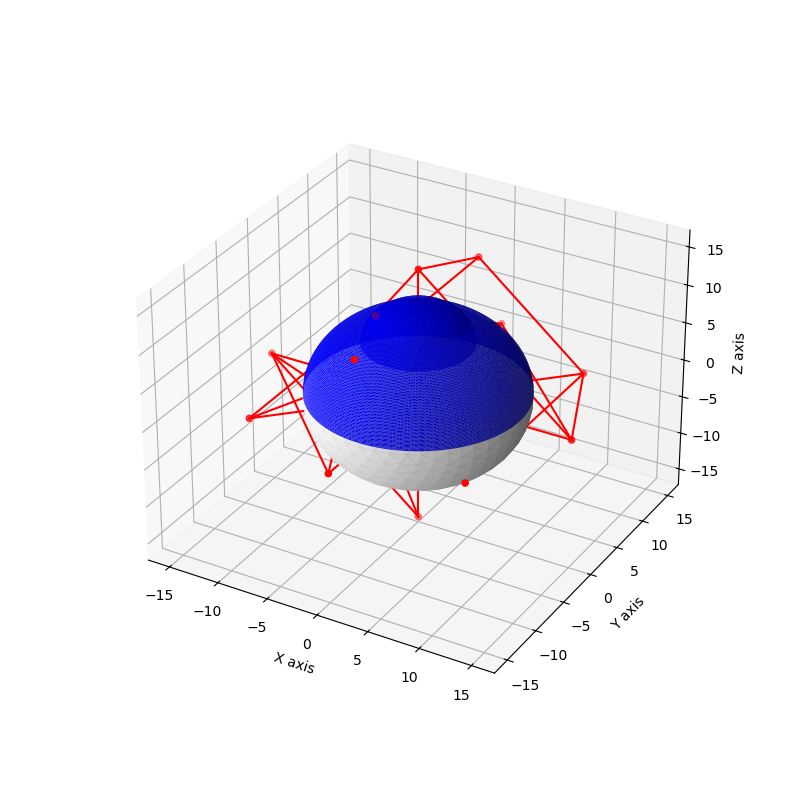

In [9]:
%matplotlib widget
cage_vertices_array = np.array(vertices)
character_vertices_array = np.array(combined_mesh.vertices)
sphere_vertices_array = np.array(sphere_mesh.vertices)
weights = compute_weights(combined_mesh.vertices, vertices )

def create_widgets(visualizer):
    dx_slider = widgets.FloatSlider(description='X Deformation', min=-10.0, max=10.0, step=0.1, value=0.0)
    dy_slider = widgets.FloatSlider(description='Y Deformation', min=-10.0, max=10.0, step=0.1, value=0.0)
    dz_slider = widgets.FloatSlider(description='Z Deformation', min=-10.0, max=10.0, step=0.1, value=0.0)
    vertex_selector = widgets.Dropdown(description='Vertex', options={f'Vertex {i}': i for i in range(len(visualizer.cage_vertices))}, value=0)

    def on_change(change):
        idx = vertex_selector.value
        deformed_cage_vertices = np.array(visualizer.cage_vertices, copy=True)
        deformed_cage_vertices[idx] += np.array([dx_slider.value, dy_slider.value, dz_slider.value])
        visualizer.update_visualization(deformed_cage_vertices, visualizer.deformed_character_vertices)

    dx_slider.observe(on_change, names='value')
    dy_slider.observe(on_change, names='value')
    dz_slider.observe(on_change, names='value')
    vertex_selector.observe(on_change, names='value')

    return widgets.VBox([vertex_selector, dx_slider, dy_slider])

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(8, 8))

ax.clear()
# Plot the sphere (eyeball) with a lower alpha for transparency
ax.plot_trisurf(sphere_mesh.vertices[:, 0], sphere_mesh.vertices[:, 1], sphere_mesh.vertices[:, 2], triangles=sphere_mesh.faces, color='white', alpha=1.0)

# Plot the combined mesh (iris and pupil)
ax.plot_trisurf(combined_mesh.vertices[:, 0], combined_mesh.vertices[:, 1], combined_mesh.vertices[:, 2], triangles=combined_mesh.faces, color='blue', alpha=1.0)

# Plot the cage vertices
ax.scatter(cage_vertices_scaled[:, 0], cage_vertices_scaled[:, 1], cage_vertices_scaled[:, 2], color='red')

# Plot the cage edges
for edge in cage_edges:
    start_point = cage_vertices_scaled[edge[0]]
    end_point = cage_vertices_scaled[edge[1]]
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], color='red')

# Setting the labels for axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Setting equal aspect ratio for all axes
max_range = np.array([cage_vertices_scaled[:, 0].max()-cage_vertices_scaled[:, 0].min(), 
                      cage_vertices_scaled[:, 1].max()-cage_vertices_scaled[:, 1].min(), 
                      cage_vertices_scaled[:, 2].max()-cage_vertices_scaled[:, 2].min()]).max() / 2.0

mid_x = (cage_vertices_scaled[:, 0].max()+cage_vertices_scaled[:, 0].min()) * 0.5
mid_y = (cage_vertices_scaled[:, 1].max()+cage_vertices_scaled[:, 1].min()) * 0.5
mid_z = (cage_vertices_scaled[:, 2].max()+cage_vertices_scaled[:, 2].min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_aspect('auto')

plt.show()
visualizer = MeshVisualizer(cage_vertices_array, character_vertices_array, sphere_vertices_array, ax)

# Create and display widgets
widgets_control = create_widgets(visualizer)
display(widgets_control)